Aleksandra Bednarczuk

# Predictors of elderly citizens willingness to stay in the neighbourhood
# Logistic regression

Original dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from scipy import stats

In [3]:
data = pd.read_pickle("survey_transformed.pkl")

In [4]:
data.head()

,ANY,NOM_DISTRICTE,Would_not_stay_in_the_neighborhood,Gender,Time_living_in_barri,Barri_evolution,Barri_future,Barri_satisfaction_of_living,Barri_comparison,GARBAGE COLLECTION,...,Social_class,Living_alone,BCN_evolution,BCN_future,BCN_satisfaction_of_living,BCN_transport,BCN_over_barri_evolution,BCN_over_barri_future,BCN_over_barri_satisfaction_of_living,BCN_over_barri_transport
0,2007,CIUTAT VELLA,0.0,0,I HAVE ALWAYS LIVED IN THE CITY,IT HAS IMPROVED,IT WILL IMPROVE,SATISFIED,"NEITHER THE BEST, NOR THE WORST",GOOD,...,MIDDLE-LOW,0,IT HAS IMPROVED,IT WILL IMPROVE,SATISFIED,GOOD,0,0,0,0
5,2007,CIUTAT VELLA,0.0,1,MORE THAN 10 YEARS,IT HAS IMPROVED,IT WILL IMPROVE,SATISFIED,"NEITHER THE BEST, NOR THE WORST",GOOD,...,MIDDLE-LOW,0,IT HAS IMPROVED,IT WILL IMPROVE,SATISFIED,GOOD,0,0,0,0
7,2007,CIUTAT VELLA,1.0,0,I HAVE ALWAYS LIVED IN THE CITY,IT IS WORSE,I DON'T KNOW / NO ANSWER,I DON'T KNOW / NO ANSWER,"NEITHER THE BEST, NOR THE WORST",GOOD,...,MIDDLE-LOW,0,IT HAS IMPROVED,IT WILL IMPROVE,NOT SATISFIED,GOOD,1,0,0,0
9,2007,CIUTAT VELLA,0.0,1,MORE THAN 10 YEARS,IT IS WORSE,IT WILL STAY THE SAME,SATISFIED,"NEITHER THE BEST, NOR THE WORST",GOOD,...,MIDDLE-LOW,0,IT HAS IMPROVED,IT WILL IMPROVE,SATISFIED,GOOD,1,1,0,1
12,2007,CIUTAT VELLA,0.0,1,I HAVE ALWAYS LIVED IN THE CITY,IT HAS IMPROVED,IT WILL IMPROVE,SATISFIED,ONE OF THE BEST,GOOD,...,MIDDLE-LOW,1,IT HAS IMPROVED,IT WILL IMPROVE,SATISFIED,GOOD,0,0,0,0


In [5]:
data.shape

(10915, 34)

In [6]:
# Dataset is imbalanced
data.groupby(['Would_not_stay_in_the_neighborhood']).size()

Would_not_stay_in_the_neighborhood
0.0    9697
1.0    1218
dtype: int64

In [7]:
data.columns.tolist()

['ANY',
 'NOM_DISTRICTE',
 'Would_not_stay_in_the_neighborhood',
 'Gender',
 'Time_living_in_barri',
 'Barri_evolution',
 'Barri_future',
 'Barri_satisfaction_of_living',
 'Barri_comparison',
 'GARBAGE COLLECTION',
 'STREETS CLEANING',
 'GREEN AREAS',
 'PUBLIC LIGHTING',
 'ASPHALT AND STREET CONSERVATION',
 'FACADES AND BUILDING CONSERVATION',
 'CIRCULATION',
 'BUS',
 'CITIZEN SECURITY IN THE CITY AS A WHOLE',
 'CITIZEN SECURITY IN THE NEIGHBORHOOD',
 'MUNICIPAL MARKETS',
 'Barri_transport',
 'Owns_a_car',
 'House_size',
 'Monthly_family_income',
 'Social_class',
 'Living_alone',
 'BCN_evolution',
 'BCN_future',
 'BCN_satisfaction_of_living',
 'BCN_transport',
 'BCN_over_barri_evolution',
 'BCN_over_barri_future',
 'BCN_over_barri_satisfaction_of_living',
 'BCN_over_barri_transport']

In [8]:
x_var = data.columns.tolist()

In [9]:
for i in ['ANY', 'Would_not_stay_in_the_neighborhood',
          'BCN_evolution', 'BCN_future', 'BCN_satisfaction_of_living', 'BCN_transport']:
    x_var.remove(i)

In [10]:
x = data[x_var]

In [11]:
y = data['Would_not_stay_in_the_neighborhood']

In [12]:
x = pd.get_dummies(x)

In [13]:
for i in [#'Gender', 'Owns_a_car','Living_alone',
    #'BCN_over_barri_evolution','BCN_over_barri_future','BCN_over_barri_satisfaction_of_living','BCN_over_barri_transport',
    
    #'NOM_DISTRICTE_CIUTAT VELLA', 'NOM_DISTRICTE_EIXAMPLE', 'NOM_DISTRICTE_GRÀCIA', 'NOM_DISTRICTE_HORTA - GUINARDÓ',
    #'NOM_DISTRICTE_LES CORTS','NOM_DISTRICTE_NOU BARRIS','NOM_DISTRICTE_SANT ANDREU','NOM_DISTRICTE_SANT MARTÍ',
    #'NOM_DISTRICTE_SANTS - MONTJUÏC',
    'NOM_DISTRICTE_SARRIÀ - SANT GERVASI',
    
    #'Time_living_in_barri_I HAVE ALWAYS LIVED IN THE CITY',
    'Time_living_in_barri_LESS THAN 10 YEARS',
    #'Time_living_in_barri_MORE THAN 10 YEARS',
    
    "Barri_evolution_I DON'T KNOW / NO ANSWER",
    #'Barri_evolution_IT HAS IMPROVED', 'Barri_evolution_IT IS THE SAME','Barri_evolution_IT IS WORSE',
    
    "Barri_future_I DON'T KNOW / NO ANSWER",
    #'Barri_future_IT WILL GET WORSE', 'Barri_future_IT WILL IMPROVE', 'Barri_future_IT WILL STAY THE SAME',
    
    "Barri_satisfaction_of_living_I DON'T KNOW / NO ANSWER",
    #'Barri_satisfaction_of_living_NOT SATISFIED', 'Barri_satisfaction_of_living_SATISFIED',
    
    "Barri_comparison_I DON'T KNOW / NO ANSWER",
    #'Barri_comparison_NEITHER THE BEST, NOR THE WORST',
    #'Barri_comparison_ONE OF THE BEST',
    #'Barri_comparison_ONE OF THE WORST',
 
    #'GARBAGE COLLECTION_BAD','GARBAGE COLLECTION_GOOD',
    "GARBAGE COLLECTION_I DON'T KNOW / NO ANSWER",
 
    #'STREETS CLEANING_BAD','STREETS CLEANING_GOOD',
    "STREETS CLEANING_I DON'T KNOW / NO ANSWER",
    
    #'GREEN AREAS_BAD','GREEN AREAS_GOOD',
    "GREEN AREAS_I DON'T KNOW / NO ANSWER",
    
    #'PUBLIC LIGHTING_BAD','PUBLIC LIGHTING_GOOD',
    "PUBLIC LIGHTING_I DON'T KNOW / NO ANSWER",
    
    #'ASPHALT AND STREET CONSERVATION_BAD','ASPHALT AND STREET CONSERVATION_GOOD',
    "ASPHALT AND STREET CONSERVATION_I DON'T KNOW / NO ANSWER",
    
    #'FACADES AND BUILDING CONSERVATION_BAD','FACADES AND BUILDING CONSERVATION_GOOD',
    "FACADES AND BUILDING CONSERVATION_I DON'T KNOW / NO ANSWER",
 
    #'CIRCULATION_BAD','CIRCULATION_GOOD',
    "CIRCULATION_I DON'T KNOW / NO ANSWER",
    
    #'BUS_BAD','BUS_GOOD',
    "BUS_I DON'T KNOW / NO ANSWER",
    
    #'CITIZEN SECURITY IN THE CITY AS A WHOLE_BAD','CITIZEN SECURITY IN THE CITY AS A WHOLE_GOOD',
    "CITIZEN SECURITY IN THE CITY AS A WHOLE_I DON'T KNOW / NO ANSWER",
 
    #'CITIZEN SECURITY IN THE NEIGHBORHOOD_BAD','CITIZEN SECURITY IN THE NEIGHBORHOOD_GOOD',
    "CITIZEN SECURITY IN THE NEIGHBORHOOD_I DON'T KNOW / NO ANSWER",

    #'MUNICIPAL MARKETS_BAD','MUNICIPAL MARKETS_GOOD',
    "MUNICIPAL MARKETS_I DON'T KNOW / NO ANSWER",
    
    #'Barri_transport_BAD','Barri_transport_GOOD','Barri_transport_NORMAL',
    "Barri_transport_I DON'T KNOW / NO ANSWER",
    
    #'House_size_101-150 M2','House_size_51-100 M2', 'House_size_> 150 M2',
    'House_size_< 50 M2',
    
    #'Monthly_family_income_1001-2000 EUROS','Monthly_family_income_2001-3000 EUROS', 'Monthly_family_income_> 3000 EUROS',
    'Monthly_family_income_< 1000 EUROS',
 
    #'Social_class_HIGH', 'Social_class_MIDDLE-HIGH', 'Social_class_MIDDLE-LOW', 'Social_class_MIDDLE-MIDDLE'
    'Social_class_LOW']:
    del x[i]

In [14]:
x = sm.add_constant(x)

In [15]:
resampling = TomekLinks()
columns = x.columns
x_resampled, y_resampled = resampling.fit_sample(x, y)
x_resampled = pd.DataFrame(data=x_resampled, columns=columns )
y_resampled= pd.DataFrame(data=y_resampled, columns=['Would_not_stay_in_the_neighborhood'])

print("length of oversampled data is ",len(x_resampled))
print("Number of people who would not stay in the neighborhood in resampled data",
      len(y_resampled[y_resampled['Would_not_stay_in_the_neighborhood']==1]))
print("Number of people who would stay in the neighborhood in resampled data",
      len(y_resampled[y_resampled['Would_not_stay_in_the_neighborhood']==0]))
print("Proportion of 'Would_not_stay_in_the_neighborhood' in resampled data is ",
      len(y_resampled[y_resampled['Would_not_stay_in_the_neighborhood']==1])/len(x_resampled))
print("Proportion of subscription data in resampled data is ",
      len(y_resampled[y_resampled['Would_not_stay_in_the_neighborhood']==0])/len(x_resampled))

length of oversampled data is  10689
Number of people who would not stay in the neighborhood in resampled data 1218
Number of people who would stay in the neighborhood in resampled data 9471
Proportion of 'Would_not_stay_in_the_neighborhood' in resampled data is  0.11394891944990176
Proportion of subscription data in resampled data is  0.8860510805500982


In [16]:
x_resampled

,const,Gender,Owns_a_car,Living_alone,BCN_over_barri_evolution,BCN_over_barri_future,BCN_over_barri_satisfaction_of_living,BCN_over_barri_transport,NOM_DISTRICTE_CIUTAT VELLA,NOM_DISTRICTE_EIXAMPLE,...,House_size_101-150 M2,House_size_51-100 M2,House_size_> 150 M2,Monthly_family_income_1001-2000 EUROS,Monthly_family_income_2001-3000 EUROS,Monthly_family_income_> 3000 EUROS,Social_class_HIGH,Social_class_MIDDLE-HIGH,Social_class_MIDDLE-LOW,Social_class_MIDDLE-MIDDLE
0,1.0,0,0.0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
1,1.0,1,0.0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
2,1.0,0,1.0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
3,1.0,1,0.0,0,1,1,0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
4,1.0,1,0.0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,1.0,1,0.0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
10685,1.0,1,1.0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
10686,1.0,1,0.0,1,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
10687,1.0,0,0.0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


In [17]:
y_resampled['Would_not_stay_in_the_neighborhood'].unique()

array([0., 1.])

In [18]:
logit_model = sm.Logit(y_resampled,x_resampled)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.289054
         Iterations 7
                                           Results: Logit
Model:                    Logit                                   Pseudo R-squared:      0.185      
Dependent Variable:       Would_not_stay_in_the_neighborhood      AIC:                   6309.3993  
Date:                     2021-04-24 16:35                        BIC:                   6782.4023  
No. Observations:         10689                                   Log-Likelihood:        -3089.7    
Df Model:                 64                                      LL-Null:               -3791.3    
Df Residuals:             10624                                   LLR p-value:           4.2462e-251
Converged:                1.0000                                  Scale:                 1.0000     
No. Iterations:           7.0000                                                                    
--------------------------------

In [19]:
result.pvalues.sort_values(ascending=False)

Barri_transport_NORMAL                                  9.989982e-01
Barri_transport_BAD                                     9.619985e-01
GARBAGE COLLECTION_BAD                                  9.606807e-01
CIRCULATION_BAD                                         9.459551e-01
Social_class_MIDDLE-HIGH                                9.143672e-01
                                                            ...     
Barri_comparison_ONE OF THE WORST                       1.653306e-05
NOM_DISTRICTE_CIUTAT VELLA                              1.606549e-05
Barri_comparison_ONE OF THE BEST                        1.490143e-07
Time_living_in_barri_MORE THAN 10 YEARS                 3.685332e-15
Time_living_in_barri_I HAVE ALWAYS LIVED IN THE CITY    4.560797e-18
Length: 65, dtype: float64

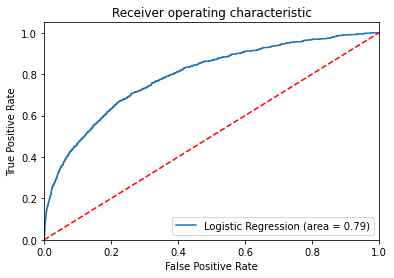

In [20]:
logit_roc_auc = roc_auc_score(y_resampled, result.predict(x_resampled))
fpr, tpr, thresholds = roc_curve(y_resampled, result.predict(x_resampled))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [20]:
# NIE POPRAWIŁAM PONIŻSZEGO FEATURE SELECTION

In [20]:
for i in ['MUNICIPAL POLICE_GOOD', 'CITIZEN SECURITY IN THE CITY AS A WHOLE_GOOD', 'BCN_over_barri_future', 
          'Gender', 'Barri_transport_GOOD']:
    del x_resampled[i]

In [21]:
logit_model = sm.Logit(y_resampled,x_resampled)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.304811
         Iterations 7
                                      Results: Logit
Model:                Logit                                Pseudo R-squared:   0.194      
Dependent Variable:   Would_not_stay_in_the_neighborhood   AIC:                2786.1900  
Date:                 2021-04-16 08:22                     BIC:                3067.5811  
No. Observations:     4426                                 Log-Likelihood:     -1349.1    
Df Model:             43                                   LL-Null:            -1672.9    
Df Residuals:         4382                                 LLR p-value:        6.4015e-109
Converged:            1.0000                               Scale:              1.0000     
No. Iterations:       7.0000                                                              
------------------------------------------------------------------------------------------
                          

In [22]:
result.pvalues.sort_values(ascending=False)

GARBAGE COLLECTION_GOOD                      9.922321e-01
NOM_DISTRICTE_GRÀCIA                         8.938374e-01
BCN_over_barri_evolution                     7.856778e-01
FACADES AND BUILDING CONSERVATION_GOOD       6.759406e-01
Owns_a_car                                   5.617183e-01
Barri_evolution_IT IS THE SAME               5.528285e-01
NOM_DISTRICTE_SANTS - MONTJUÏC               5.459152e-01
CIRCULATION_GOOD                             5.388068e-01
NOM_DISTRICTE_SANT ANDREU                    4.883139e-01
Monthly_family_income_< 1000 EUROS           4.722098e-01
NOM_DISTRICTE_NOU BARRIS                     3.905991e-01
Social_class_MIDDLE-MIDDLE                   3.207760e-01
Social_class_MIDDLE-LOW                      2.648302e-01
Social_class_LOW                             2.621467e-01
PUBLIC LIGHTING_GOOD                         2.504642e-01
STREETS CLEANING_GOOD                        2.335794e-01
House_size_51-100 M2                         2.213443e-01
Barri_evolutio

In [23]:
print(result.get_margeff().summary())

                Logit Marginal Effects               
Dep. Variable:     Would_not_stay_in_the_neighborhood
Method:                                          dydx
At:                                           overall
                                               dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Owns_a_car                                    0.0062      0.011      0.580      0.562      -0.015       0.027
Living_alone                                  0.0189      0.011      1.672      0.095      -0.003       0.041
BCN_over_barri_evolution                     -0.0040      0.015     -0.272      0.786      -0.033       0.025
BCN_over_barri_satisfaction_of_living         0.0468      0.022      2.154      0.031       0.004       0.089
BCN_over_barri_transport                      0.0246      0.014      1.711      0.087      -0.004       0.053
NOM_DISTRICTE_

In [24]:
result.pred_table()

array([[3805.,   65.],
       [ 453.,  103.]])

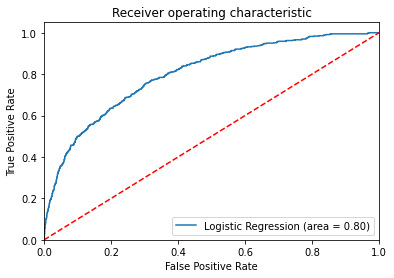

In [26]:
logit_roc_auc = roc_auc_score(y_resampled, result.predict(x_resampled))
fpr, tpr, thresholds = roc_curve(y_resampled, result.predict(x_resampled))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()